In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%pip install teeplot
from teeplot import teeplot as tp
from matplotlib.patches import Patch
from scipy.stats import kruskal
from IPython.display import display





# OSF identifier
data_id = "z54jc"

# load CSV file into DataFrame directly from OSF URL
df = pd.read_csv(f"https://osf.io/{data_id}/download")


Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


/tmp/ipykernel_11369/210233810.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["T Upper Bound"] = data["T Upper Bound"].replace({
/tmp/ipykernel_11369/210233810.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Algorithm"] = data["Algorithm"].replace({
/tmp/ipykernel_11369/210233810.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.p

,T Upper Bound,H‑statistic,p‑value
0,steady,0.661,0.416136
1,stretched,3.200,0.073628
2,tilted,1.470,0.225389


teeplots/hue=t-upper-bound+palette=paired+viz=plot-mean-real-execution-time-ps+x=algorithm+y=real-time-per-site-ns+ext=.pdf
teeplots/hue=t-upper-bound+palette=paired+viz=plot-mean-real-execution-time-ps+x=algorithm+y=real-time-per-site-ns+ext=.png


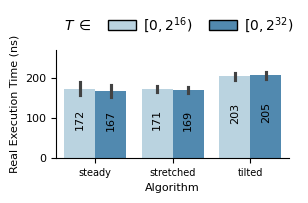

In [2]:


def plot_mean_real_execution_time_ps(data, **kwargs):
    # rename the numeric T Upper Bounds
    data = data[data["Surface Size (S)"] == 256]
    data["T Upper Bound"] = data["T Upper Bound"].replace({
        65536: r"$[0, 2^{16})$",
        4294967296: r"$[0, 2^{32})$"
    })

    # Rename the algorithm labels
    data["Algorithm"] = data["Algorithm"].replace({
        "steady_assign_storage_site_batched": "steady",
        "stretched_assign_storage_site_batched": "stretched",
        "tilted_assign_storage_site_batched": "tilted",
    })

    # convert to nanoseconds per site
    data["Real Time Per Site (ns)"] = (data["Real Execution Time"] * 1e9) / data["T Size"]

    # restrict & recode exactly as in your plotting function
    data_256 = df[df["Surface Size (S)"] == 256].copy()
    data_256["T Upper Bound"] = data_256["T Upper Bound"].replace({
        65536: r"$[0, 2^{16})$",
        4294967296: r"$[0, 2^{32})$"
    })

    # work off of the same data
    data_256 = data.copy()

    # one KW test per T‑Upper‑Bound
    kruskal_results = []
    for bound, grp in data_256.groupby("Algorithm"):
        # collect the per‑Algorithm samples
        samples = [
            g["Real Time Per Site (ns)"].values
            for _, g in grp.groupby("T Upper Bound")
        ]
        stat, p_val = kruskal(*samples)
        kruskal_results.append({
            "T Upper Bound": bound,
            "H‑statistic": round(stat, 3),
            "p‑value": p_val
        })


    kruskal_df = pd.DataFrame(kruskal_results)
    display(kruskal_df)


    # group by Algorithm and T Upper Bound, compute the mean per-site time
    # grouped = data.groupby(["Algorithm", "T Upper Bound"], as_index=False)["Real Time Per Site (ns)"].mean()

    # bar plot
    plt.figure(figsize=(3, 2)) # these are IRL dimensions

    # more bar plot
    ax = sns.barplot(data=data, **kwargs, alpha=0.85)

    # Remove top and right spines for cleaner frame
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add labels to each bar
    for container in ax.containers:
        labels = [f"{int(v.get_height())}" if v.get_height() > 0 else '' for v in container]
        ax.bar_label(container, labels=labels, fmt='%d', fontsize=8, padding=3, rotation=90, label_type = 'center')

    # better readability
    plt.xlabel("Algorithm", fontsize=8)
    plt.ylabel("Real Execution Time (ns)", fontsize=8)

    # keep x-axis labels horizontal
    plt.xticks(fontsize=7, rotation=0, ha='center')
    plt.yticks(fontsize=8)

    # ylim adjustment
    ax.set_ylim(0, ax.get_ylim()[1] * 1.2)

    # legend
    # Get the original handles and labels
    handles, labels = ax.get_legend_handles_labels()

    # Reconstruct proper colored handles
    colors = [bar.patches[0].get_facecolor() for bar in ax.containers[:2]]
    color_handles = [Patch(facecolor=c, edgecolor='black') for c in colors]

    # Construct the legend with a dummy handle for the title
    title_handle = Patch(facecolor='none', edgecolor='none')  # invisible box
    legend_handles = [title_handle] + color_handles
    legend_labels = [r"$\it{T\;\in}$"] + labels


    # legend
    plt.legend(
        handles=legend_handles,
        labels=legend_labels,
        fontsize=10,
        loc="lower center",
        bbox_to_anchor=(0.45, 1.02),
        ncol=3,
        columnspacing=1.2,
        handletextpad=0.5,
        frameon=False
    )





    # layout tweaks
    # plt.subplots_adjust(bottom=0.4)
    plt.subplots_adjust(top=0.65)
    # plt.tight_layout(pad=1)

# teeplot
tp.tee(plot_mean_real_execution_time_ps, data=df, x="Algorithm", y="Real Time Per Site (ns)", hue="T Upper Bound", palette="Paired")
